<center>

# Avance proyecto final: **Crecimiento Poblacional en México (2022-2100)**

## **Manuel Jesús Casillas Olivier**

### **Temas Selectos de Física Computacional I: Inteligencia Artificial en la Física**

</center>

---







**Breve introducción:**

> El 15 de noviembre del 2022 la población mundial alcanzó el número de 8 mil millones de personas. Nuevamente surge el debate de si la cantidad de personas habitando la tierra es "considerablemente" relevante para el aceleramiento del cambio climático, aumento en la contaminación del aire, tierra y agua, la extinción de especies producto del desplazamiento de sus hábitats por el incremento de las actividades humanas, la lucha por el espacio, etc. Sin duda la sobrepoblación es un problema, pero tendría que discutirse si tiene más que ver más con factores políticos y económicos que con un problema númerico en sí.

Según las cifras de [Expansión](https://datosmacro.expansion.com/paises/mexico#:~:text=M%C3%A9xico,%20con%20una%20poblaci%C3%B3n%20de,66%20habitantes%20por%20Km2.), en 2022 la población de México alcanzó la cifra de 130,262,220 personas.






<center>

## **1. Problema a resolver:**

</center>


Se realizará un modelo que predecirá la evolución en el incremento de la población en México hasta 2100. Se puede caracterizar al crecimiento de la población con los siguientes rasgos e inputs:

*   Año  ( $t$ )
*   Población de acuerdo al año ( $P(t)$ )
*   Incremento porcentual de la población ( $ΔP$ )
*   Tasa de natalidad ( $ΔN$ )
*   Tasa de mortalidad ( $∇M$ )

La variable más importante en este problema es el tiempo en años dado que el resto de rasgos son directamente dependientes de éste. La población de acuerdo a cada año así como el incremento porcentual de la población, la tasa de natalidad y la tasa de mortalidad son los rasgos que servirán al modelo de aprendizaje predecir la problación en futuros años. El cual sería el output de interés para la solución del problema y el objetivo fundamental de este proyecto. Además, nótese que:

<center>

$ΔP(t_i) = \frac{P(t_{i+1}) - P(t_i)}{P(t_i)}$

</center>

Los anteriores rasgos e inputs son obtenidos del sitio web del [Banco Mundial](https://datos.bancomundial.org/indicador/sp.pop.grow?locations=MX) y fueron descargados en formato .csv para un mejor manejo con la paquetería pandas de python. Dicho archivo se encuentra adjunto a este notebook, en caso de que se deseé ser consultado.


---



In [1]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import initializers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import time

np.random.seed(4)


In [24]:

# 2. Análisis de datos

"""
Cabe destacar que los rasgos Inc (incremento), TN (tasa de natalidad) y TM (tasa de mortalidad) se encuentran en porcentaje %,
así como Pob (población en el respectivo año) se encuentra en millones de habitantes, se eliminó el fromato de tabla de cada rasgo
para evitar complicaciones con el análisis de datos al convertir el archivo .csv a data frame de pandas
"""
df = pd.read_csv("poblacion.csv")

df.head()


,Año,Pob,Inc,TN,TM
0,1961,38.97,3.16,44.9,11.9
1,1962,40.20,3.15,44.7,11.6
2,1963,41.46,3.15,44.5,11.3
3,1964,42.77,3.16,44.4,11.1
4,1965,44.12,3.16,44.2,10.9


In [25]:

# Para el problema se podrían descartar las estadísticas generales de los primeros dos rasgos
df.describe()


,Año,Pob,Inc,TN,TM
count,61.000000,61.000000,61.000000,60.000000,60.000000
mean,1991.000000,84.744918,3.951475,30.028333,6.786667
std,17.752934,27.490925,14.733089,9.329507,2.171110
min,1961.000000,38.970000,1.030000,17.000000,4.700000
25%,1976.000000,61.240000,1.450000,21.600000,5.175000
50%,1991.000000,85.510000,1.910000,28.500000,5.900000
75%,2006.000000,107.560000,2.830000,38.825000,8.075000
max,2021.000000,130.260000,117.000000,44.900000,11.900000


Text(0.5, 0, 'Tasa de mortalidad')

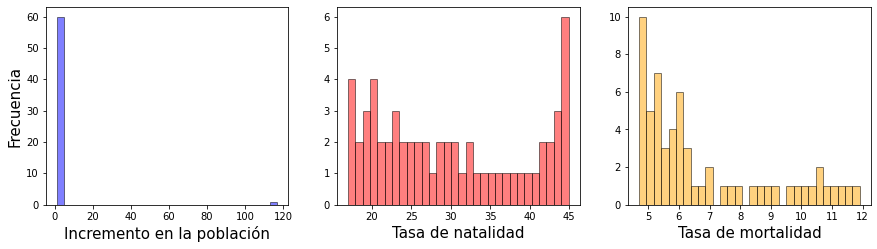

In [28]:

"""
Con los métodos de matplotlib se grafican los histogramas mediante el método .hist(), quizás sea mejor graficar los datos directamente
respecto al tiempo en vez de realizar los histogramas
"""
plt.figure(figsize = (20,8)) 

ax1 = plt.subplot(2,4,1)
ax2 = plt.subplot(2,4,2)
ax3 = plt.subplot(2,4,3)

ax1.hist(df.Inc, bins = 30, color = 'blue', edgecolor = 'black', alpha = 0.5)
ax1.set_xlabel('Incremento en la población', size = 15)
ax1.set_ylabel('Frecuencia', size = 15)

ax2.hist(df.TN, bins = 30, color = 'red', edgecolor='black', alpha = 0.5)
ax2.set_xlabel('Tasa de natalidad', size = 15)

ax3.hist(df.TM, bins = 30, color = 'orange', edgecolor = 'black', alpha = 0.5)
ax3.set_xlabel('Tasa de mortalidad', size = 15)


In [30]:
"""
Se reordena aleatoriamente el data frame, para evitar correlaciones posibles entre los datos y mejorar el entrenamiento (tal vez esto no sea
necesario)
"""
df = df.sample(frac = 1) 


In [31]:

# 3. Separación de los datos 

# Para el conjunto de pruebas, tomando un 10%
test_ratio = 0.1   

# Para el conjunto de entrenamiento, se toma el 90% de la dimensión total de los registros usando .values, len() e int()
train_ratio = int((1.0 - test_ratio) * len(df.values[:,:]))   

# Se usa el método .iloc de pandas para seleccionar los registros por renglon y columna
df_train = df.iloc[0:train_ratio,:]
df_test  = df.iloc[train_ratio:,:]

# Con .shape de pandas se muestran las dimensiones de los conjuntos anteriores
print("Las dimensiones del conjunto de entrenamiento son:", df_train.shape)
print("Las dimensiones del conjunto de pruebas son:", df_test.shape)


Las dimensiones del conjunto de entrenamiento son: (54, 5)
Las dimensiones del conjunto de pruebas son: (7, 5)


Al ser un incremento no lineal tal vez, no sea necesario normalizar, usando que:

$$x_{i,norm} = \dfrac{x_{i}-\mu}{\sigma}$$
    
$$y_{i,norm} = \dfrac{y_{i}-\mu}{\sigma}$$

In [32]:

"""
Usando las expresiones anteriores, con los métodos .mean() y std() de pandas se obtienen el promedio y la desviación
estándar del conjunto de entrenamiento respectivamente
"""
df_train_norm = (df_train - df_train.mean()) / df_train.std()

# Normalizando el conjunto de pruebas con el promedio y desviación del conjunto de entrenamiento
df_test_norm = (df_test - df_train.mean()) / df_train.std()


In [33]:

#El método .values extraen por medio de las variables X y Y las columnas del Data frame convierténdose en arreglos numpy
train_x = df_train_norm.values[:,:-1]
train_y = df_train_norm.values[:,-1:]

test_x = df_test_norm.values[:,:-1]
test_y = df_test_norm.values[:,-1:]


In [34]:

# Se transponen con .T los conjuntos para que sean óptimos en la aplicación para la red neuronal
x_train = train_x.T
x_test = test_x.T

y_train = train_y.T
y_test = test_y.T


In [35]:

# 4

import networkx as nx

class Network(object):
    
    def  __init__ (self,sizes):
        self.num_layers = len(sizes)
        print("It has", self.num_layers, "layers,")
        self.sizes = sizes
        print("with the following number of nodes per layer",self.sizes)
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(sizes[:-1], sizes[1:])]
        
    def feedforward(self, x_of_sample):
        """Return the output of the network F(x_of_sample) """        
        for b, w in zip(self.biases, self.weights):
            x_of_sample = sigmoid(np.dot(w, x_of_sample)+b)
        return x_of_sample
    
    def graph(self,sizes):
        a=[]
        ps={}
        Q = nx.Graph()
        for i in range(len(sizes)):
            Qi=nx.Graph()    
            n=sizes[i]
            nodos=np.arange(n)
            Qi.add_nodes_from(nodos)
            l_i=Qi.nodes
            Q = nx.union(Q, Qi, rename = (None, 'Q%i-'%i))
            if len(l_i)==1:
                ps['Q%i-0'%i]=[i/(len(sizes)), 1/2]
            else:
                for j in range(len(l_i)+1):
                    ps['Q%i-%i'%(i,j)]=[i/(len(sizes)),(1/(len(l_i)*len(l_i)))+(j/(len(l_i)))]
            a.insert(i,Qi)
        for i in range(len(a)-1):
            for j in range(len(a[i])):
                for k in range(len(a[i+1])):
                    Q.add_edge('Q%i-%i' %(i,j),'Q%i-%i' %(i+1,k))
        nx.draw(Q, pos = ps)
                

In [36]:

"""
La siguiente función genera la cantidad de neuronas por capa de la red neuronal FFF, se conviene el número de nodos de la
capa oculta con n_h = 8
"""
def layer_sizes(X, Y, n_h):
    
    n_x = X.shape[0] 
    n_h = n_h
    n_y = Y.shape[0]
    
    return (n_x, n_h, n_y)


In [37]:

# Comprobando
n_h = 8
n_x, n_h, n_y = layer_sizes(x_train, y_train, n_h = n_h)

print("No. de neuronas en la capa de entrada:", n_x)
print("No. de neuronas en la capa oculta:", n_h)
print("No. de neuronas en la capa de salida:", n_y)


No. de neuronas en la capa de entrada: 4
No. de neuronas en la capa oculta: 8
No. de neuronas en la capa de salida: 1


It has 3 layers,
with the following number of nodes per layer [4, 8, 1]


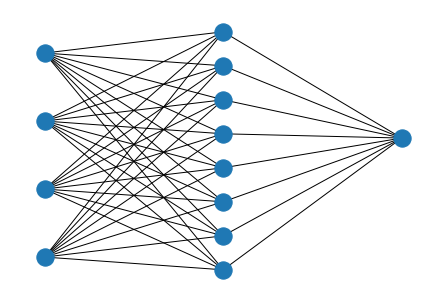

In [38]:

# Utilizando la clase Network se realiza el esquema de la red neuronal con las características pedidas
layers = [n_x, n_h, n_y]
net = Network(layers)
net.graph(layers)


In [39]:

# Personalmente me aseguro de tener bien instalado keras en mi entorno de anaconda navigator
keras.__version__


'2.9.0'

In [40]:

def architecture(input_shape, activation):
    
    """
    Implementación del modelo secuencial (izquierda-derecha) con el método Sequential() de keras.
    Con los métodos de keras .add se añade una capa, Dense() para conectar todos los nodos actuales con los nodos 
    anteriores específicando n_h = 8 número de nodos en el caso de nuestro modelo y usando la notación kernel_initializer
    como los pesos iniciales en una distribución uniforme y los bias en cero
    """
    model = Sequential() 
    
    # Capa de entrada y capa oculta
    model.add(Dense(8, kernel_initializer = 'uniform', bias_initializer = 'zeros', 
                    activation=activation, 
                    input_shape=input_shape))
    
    # Capa de salida
    model.add(Dense(1, kernel_initializer = 'uniform', bias_initializer = 'zeros', 
                    activation = activation))
    
    return model



In [41]:

# Como dimensión de entrada para nuestro problema en partícular se toma el número de rasgos (n_x = 4)
input_shape = (4,)

# Como activador se usa la notación 'tanh' para la tangente hiperbólica
model_keras = architecture(input_shape = input_shape, activation = 'tanh')


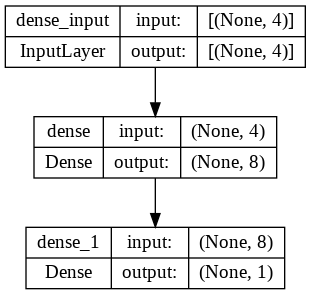

In [42]:

"""
El método plot_model() de keras devuelve una imagen donde se visualizan de manera gráfica todas las capas con sus
respectivos numero de nodos que entran y salen en la red neuronal
"""
plot_model(model_keras, to_file = 'model.png', show_shapes = True, rankdir = 'TB', 
      expand_nested = True, show_layer_names = True, dpi = 96)


In [43]:

# Con el método .summary() se muestra una tabla con la información de todas las capas de la red neuronal
model_keras.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


In [44]:

# Valor alpha
lr = 0.0001

# Optimizador Adam
opt = Adam(learning_rate = lr)

# Con los métodos losses.MeanSquaredError() "apilados" se define al costo o pérdidas con el error cuadrático medio
loss = tf.keras.losses.MeanSquaredError()

# Análogamente con la presición pero mediante el método .metrics
acc = tf.keras.metrics.MeanSquaredError()

# Con el método .compile se compila la red neuronal usando la métrica basada en los anteriores hiperparámetros
model_keras.compile(loss = loss, 
              optimizer = opt,
              metrics = [acc])



In [45]:

# Número de épocas para el entrenamiento
epochs = 150

"""
Con el método .time() de la paquetería time se genera un reloj interno que devuelve el tiempo de ejecución en que un 
código es ejecutado por la computador
"""
start_time = time.time()

"""
Se indica el porcentaje de muestras en float para el conjunto de validación, en este caso 10% ~ 0.1, por lo que para 
el conjunto de entrenamiento sería el 90% ~ 0.9 
"""
val_split = 0.1

"""
Con el método .fit se entrena al modelo model_keras, con el parámetro batch_size se especifica el número de muestras por
lote y así que el entrenamiento sea más óptimo
"""
history_model = model_keras.fit(train_x, train_y,
                          epochs = epochs,
                          batch_size = 32,
                          validation_split = val_split, 
                          shuffle= True,
                          verbose = 2)

end_time = time.time()

print("Time for training: {:10.4f}s".format(end_time - start_time))


Epoch 1/150
2/2 - 1s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan - 761ms/epoch - 381ms/step
Epoch 2/150
2/2 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan - 28ms/epoch - 14ms/step
Epoch 3/150
2/2 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan - 26ms/epoch - 13ms/step
Epoch 4/150
2/2 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan - 24ms/epoch - 12ms/step
Epoch 5/150
2/2 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan - 25ms/epoch - 12ms/step
Epoch 6/150
2/2 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan - 26ms/epoch - 13ms/step
Epoch 7/150
2/2 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan - 25ms/epoch - 12ms/step
Epoch 8/150
2/2 - 0s - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_sq

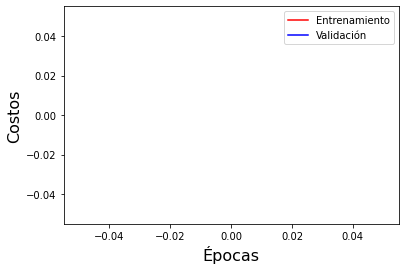

In [46]:

plt.plot(history_model.history['loss'], 'red')
plt.plot(history_model.history['val_loss'], 'blue')
plt.ylabel('Costos', size=16)
plt.xlabel('Épocas', size=16)
plt.legend(['Entrenamiento', 'Validación'], loc='upper right');


In [47]:

scores = model_keras.evaluate(test_x, test_y)
print('Test loss:', scores[0])


1/1 [==============================] - 0s 18ms/step - loss: nan - mean_squared_error: nan
Test loss: nan


In [48]:

# 5

predictions = model_keras.predict(test_x)
print(len(predictions))


1/1 [==============================] - 0s 257ms/step
7


In [51]:

# El modelo falla completamente
(predictions[6] * df_train.std()) + df_train.mean()


Año   NaN
Pob   NaN
Inc   NaN
TN    NaN
TM    NaN
dtype: float64